## Multimodal Brain Tumour Segmentation Using U-Net

###### The automatic segmentation of glioma sub-regions in the brain images is of great importance as it helps in easy, quick, and better diagnosis, giving required treatment in time, assessment of tumour progression before and after treatment, and also to check the success of the treatment strategy.

In [6]:
# Importing required packages
import os
import numpy as np

In [7]:
#Installing tqdm
!pip install tqdm

In [8]:
#Installing SimpleITK
!pip install SimpleITK

In [9]:
#Installing nilearn
!pip install nilearn

#### Reading and loading the data

In [10]:
#Importing required packages
import os
from nilearn import plotting
import SimpleITK as sitk
from tqdm import tqdm
import numpy as np

In [11]:
#Setting the path to the folder where the data is stored
path='./Training_Data_HGG_LGG/'

In [12]:
#Checking the folder contanining the images
os.listdir(path)

['BraTS20_Training_263',
 'BraTS20_Training_005',
 'BraTS20_Training_027',
 'BraTS20_Training_030',
 'BraTS20_Training_013',
 'BraTS20_Training_287',
 'BraTS20_Training_295',
 'BraTS20_Training_275',
 'BraTS20_Training_294',
 'BraTS20_Training_274',
 'BraTS20_Training_261',
 'BraTS20_Training_021',
 'BraTS20_Training_007',
 'BraTS20_Training_035',
 'BraTS20_Training_004',
 'BraTS20_Training_023',
 'BraTS20_Training_010',
 'BraTS20_Training_024',
 'BraTS20_Training_280',
 'BraTS20_Training_033',
 'BraTS20_Training_281',
 'BraTS20_Training_037',
 'BraTS20_Training_268',
 'BraTS20_Training_025',
 'BraTS20_Training_014',
 'BraTS20_Training_276',
 'BraTS20_Training_277',
 'BraTS20_Training_008',
 'BraTS20_Training_009',
 'BraTS20_Training_289',
 'BraTS20_Training_019',
 'BraTS20_Training_288',
 'BraTS20_Training_022',
 'BraTS20_Training_273',
 'BraTS20_Training_034',
 'BraTS20_Training_031',
 'BraTS20_Training_262',
 'BraTS20_Training_285',
 'BraTS20_Training_016',
 'BraTS20_Training_286',


In [13]:
# Function for reading the images,concatenating the fourimage modalities, seggregating the ground truth images and converting them into arrays
def load_data(path):
    my_dir = sorted(os.listdir(path))
    data = []
    gt = []  
    for p in tqdm(my_dir):
        if not p.startswith('.'):
            data_list = sorted(os.listdir(path+p))
            data_list = [item for item in data_list if not item.startswith('.')]

            img_itk = sitk.ReadImage(path + p + '/'+ data_list[0])
            flair = sitk.GetArrayFromImage(img_itk)
            img_itk = sitk.ReadImage(path + p + '/'+ data_list[1])
            seg =  sitk.GetArrayFromImage(img_itk)
            img_itk = sitk.ReadImage(path + p + '/'+ data_list[2])    
            t1 =  sitk.GetArrayFromImage(img_itk)
            img_itk = sitk.ReadImage(path + p + '/'+ data_list[3])
            t1ce =  sitk.GetArrayFromImage(img_itk)
            img_itk = sitk.ReadImage(path + p + '/'+ data_list[4])
            t2 =  sitk.GetArrayFromImage(img_itk)
            data.append([flair,t1,t1ce,t2])
            gt.append(seg)
    data = np.asarray(data,dtype=np.float32)
    gt = np.asarray(gt,dtype=np.uint8)
    return data,gt

In [14]:
# Loading the images
data,gt = load_data(path)   

100%|██████████| 78/78 [00:29<00:00,  2.67it/s]


In [15]:
#Checking the shape of the data and gt folders
data.shape,gt.shape

((77, 4, 155, 240, 240), (77, 155, 240, 240))

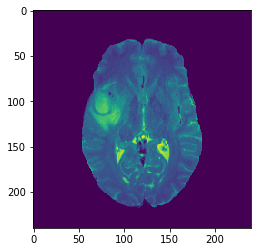

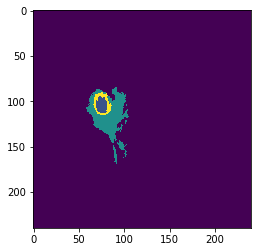

In [16]:
#Showing the images from data and gt folders
import matplotlib.pyplot as plt
 
plt.imshow(data[1,3,65,:,:])
plt.show()
plt.imshow(gt[1,65,:,:])
plt.show()

In [17]:
#Saving the data as numpy arrays
#np.save('data.npy',data)
#np.save('gt.npy',gt)

In [18]:
# Loading saved data for usage
#data = np.load('data.npy')
#gt = np.load('gt.npy')

In [19]:
#Checking the shape of the data
data.shape,gt.shape,data.dtype,gt.dtype

((77, 4, 155, 240, 240), (77, 155, 240, 240), dtype('float32'), dtype('uint8'))

In [20]:
#Transposing the shape of the data
data = np.transpose(data,(0,2,3,4,1))
#gt_np = np.transpose(gt_np,(0,2,3,4,1))

In [21]:
#Checking the shape of the data
data.shape,gt.shape,data.dtype,gt.dtype

((77, 155, 240, 240, 4), (77, 155, 240, 240), dtype('float32'), dtype('uint8'))

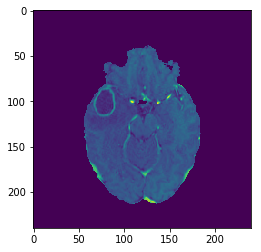

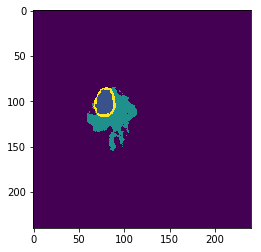

In [22]:
#Showing the images
import matplotlib.pyplot as plt
plt.imshow(data[1,50,:,:,2])
plt.show()
plt.imshow(gt[1,50,:,:])
plt.show()

#### Data Pre-processing

In [23]:
#Checking the shape
data.shape,gt.shape

((77, 155, 240, 240, 4), (77, 155, 240, 240))

In [24]:
#Taking Only from 30th slice till 120th slice for creating the data and also cropping the images to discard useless background 
#So, from 240x240x4 each image now becomes of shape 192x192x4 taking all 4 modalities'''

In [25]:
data = data[:,30:120,30:222,30:222,:].reshape([-1,192,192,4])
gt = gt[:,30:120,30:222,30:222].reshape([-1,192,192,1])

In [26]:
#Checking the shape
data.shape,gt.shape

((6930, 192, 192, 4), (6930, 192, 192, 1))

In [27]:
#converting ground truth value of 4 to 3 to do one hot encoding (Consider value 3 in results in output as class 4)
gt[np.where(gt==4)]=3   

#### Train-Test split

In [28]:
#Splitting the data into training, validation and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data, gt, test_size=0.20, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25,random_state=42)

In [29]:
#Checking the shape
X_train.shape,Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((4158, 192, 192, 4),
 (4158, 192, 192, 1),
 (1386, 192, 192, 4),
 (1386, 192, 192, 1),
 (1386, 192, 192, 4),
 (1386, 192, 192, 1))

In [30]:
#%tensorflow_version 1.x

In [31]:
#Normalizing the data
from keras.utils import to_categorical,normalize
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
X_train = (X_train-np.mean(X_train))/np.max(X_train)
X_test = (X_test-np.mean(X_test))/np.max(X_test)
X_val = (X_val-np.mean(X_val))/np.max(X_val)

Using TensorFlow backend.


In [32]:
#Checking the shape
X_train.shape,Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((4158, 192, 192, 4),
 (4158, 192, 192, 4),
 (1386, 192, 192, 4),
 (1386, 192, 192, 4),
 (1386, 192, 192, 4),
 (1386, 192, 192, 1))

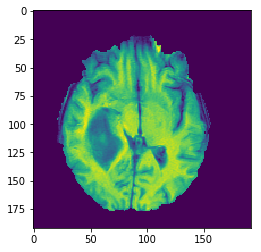

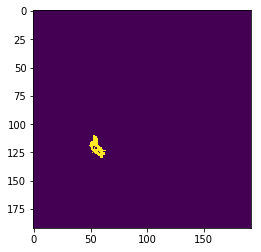

In [33]:
#Showing the images
plt.imshow(X_train[2,:,:,1])
plt.show()
plt.imshow(Y_train[2,:,:,3])
plt.show()

In [34]:
#Saving the data 
#np.save('./Training_Data/X_train.npy',X_train)
#np.save('./Training_Data/Y_train.npy',Y_train)
#np.save('./Validation_Data/X_val.npy',X_val)
#np.save('./Validation_Data/Y_val.npy',Y_val)
#np.save('./Test_Data/X_test.npy',X_test)
#np.save('./Test_Data/Y_test.npy',Y_test)

#### U-Net Implementation

In [35]:
#Using 4 sets made by pre-processing one by one each having training set of 3780, validaiton of 1260 and test data of 1260 slices of mri scans

In [36]:
#Loading the training data
#X_train = np.load('./Training_Data/X_train.npy')
#Y_train = np.load('./Training_Data/Y_train.npy')

In [37]:
#Loading the validation data
#X_val = np.load('./Validation_Data/X_val.npy')
#Y_val = np.load('./Validation_Data/Y_val.npy')

In [38]:
#Checking the shape
X_train.shape,Y_train.shape,X_val.shape,Y_val.shape

((4158, 192, 192, 4),
 (4158, 192, 192, 4),
 (1386, 192, 192, 4),
 (1386, 192, 192, 4))

In [ ]:
# #Creating ImageDataGenerator for data augmentation
# from keras.preprocessing.image import ImageDataGenerator
# train_datagen = ImageDataGenerator(
#         rotation_range=20,
#         zoom_range=0.15,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.15,
#         horizontal_flip=True,
#         fill_mode="nearest")
#  test_datagen = ImageDataGenerator()

In [ ]:
# #Batching
# batch_size = 8
# train_generator = train_datagen.flow(X_train, Y_train, batch_size=batch_size,save_to_dir='./Augmented_Images')
# valid_generator = test_datagen.flow(X_val, Y_val, batch_size=batch_size)
# test_generator = test_datagen.flow(X_test,Y_test, batch_size=1)

In [39]:
#Importing required packages
#%tensorflow_version 1.x
#import tensorflow.compat.v1 as tf
from keras.models import Model
from keras.layers import MaxPooling2D,Conv2D,Dense,BatchNormalization,concatenate,Input,Dropout,Maximum,Activation,Dense,Flatten,UpSampling2D,Conv2DTranspose
from keras.optimizers import SGD,Adam,RMSprop
import keras.callbacks as callbacks
import keras.initializers as initializers
from keras.callbacks import Callback
from keras import regularizers

In [40]:
#!pip install tensorflow-gpu==1.15.2

In [41]:
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

In [42]:
############################################ U-net #############################################

############ Encoder #############
input_ = Input(shape=(192,192,4),name='input')                                              

block1_conv1 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv1')(input_)
block1_conv2 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv2')(block1_conv1)
block1_norm = BatchNormalization(name='block1_batch_norm')(block1_conv2)
block1_pool = MaxPooling2D(name='block1_pool')(block1_norm)

block2_conv1 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv1')(block1_pool)
block2_conv2 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv2')(block2_conv1)
block2_norm = BatchNormalization(name='block2_batch_norm')(block2_conv2)
block2_pool = MaxPooling2D(name='block2_pool')(block2_norm)

encoder_dropout_1 = Dropout(0.2,name='encoder_dropout_1')(block2_pool)

block3_conv1 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv1')(encoder_dropout_1)
block3_conv2 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv2')(block3_conv1)
block3_norm = BatchNormalization(name='block3_batch_norm')(block3_conv2)
block3_pool = MaxPooling2D(name='block3_pool')(block3_norm)

block4_conv1 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv1')(block3_pool)
block4_conv2 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv2')(block4_conv1)
block4_norm = BatchNormalization(name='block4_batch_norm')(block4_conv2)
block4_pool = MaxPooling2D(name='block4_pool')(block4_norm)
################### Encoder end ######################

block5_conv1 = Conv2D(1024,3,padding='same',activation='relu',name='block5_conv1')(block4_pool)
# encoder_dropout_2 = Dropout(0.2,name='encoder_dropout_2')(block5_conv1)

########### Decoder ################

up_pool1 = Conv2DTranspose(1024,3,strides = (2, 2),padding='same',activation='relu',name='up_pool1')(block5_conv1)
merged_block1 = concatenate([block4_norm,up_pool1],name='merged_block1')
decod_block1_conv1 = Conv2D(512,3, padding = 'same', activation='relu',name='decod_block1_conv1')(merged_block1)

up_pool2 = Conv2DTranspose(512,3,strides = (2, 2),padding='same',activation='relu',name='up_pool2')(decod_block1_conv1)
merged_block2 = concatenate([block3_norm,up_pool2],name='merged_block2')
decod_block2_conv1 = Conv2D(256,3,padding = 'same',activation='relu',name='decod_block2_conv1')(merged_block2)

decoder_dropout_1 = Dropout(0.2,name='decoder_dropout_1')(decod_block2_conv1)

up_pool3 = Conv2DTranspose(256,3,strides = (2, 2),padding='same',activation='relu',name='up_pool3')(decoder_dropout_1)
merged_block3 = concatenate([block2_norm,up_pool3],name='merged_block3')
decod_block3_conv1 = Conv2D(128,3,padding = 'same',activation='relu',name='decod_block3_conv1')(merged_block3)

up_pool4 = Conv2DTranspose(128,3,strides = (2, 2),padding='same',activation='relu',name='up_pool4')(decod_block3_conv1)
merged_block4 = concatenate([block1_norm,up_pool4],name='merged_block4')
decod_block4_conv1 = Conv2D(64,3,padding = 'same',activation='relu',name='decod_block4_conv1')(merged_block4)
############ Decoder End ######################################

# decoder_dropout_2 = Dropout(0.2,name='decoder_dropout_2')(decod_block4_conv1)

pre_output = Conv2D(64,1,padding = 'same',activation='relu',name='pre_output')(decod_block4_conv1)

output = Conv2D(4,1,padding='same',activation='softmax',name='output')(pre_output)

model = Model(inputs = input_, outputs = output)
model.summary()

W0202 10:03:50.428024 140290742208320 module_wrapper.py:139] From /mnt/disks/user/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0202 10:03:50.767592 140290742208320 module_wrapper.py:139] From /mnt/disks/user/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0202 10:03:50.914057 140290742208320 module_wrapper.py:139] From /mnt/disks/user/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0202 10:03:50.914932 140290742208320 module_wrapper.py:139] From /mnt/disks/user/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session i

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 192, 192, 4)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 192, 192, 64) 2368        input[0][0]                      
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 192, 192, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_batch_norm (BatchNormali (None, 192, 192, 64) 256         block1_conv2[0][0]               
__________________________________________________________________________________________________
block1_poo

In [43]:
#Installing graphviz
#!apt install graphviz

In [44]:
#Plotting U-Net model
#from keras.utils import  plot_model
#plot_model(model,to_file='unet.png',show_shapes=True)

In [45]:
#  class LRFinder(Callback):    
#      '''
#      A simple callback for finding the optimal learning rate range for your model + dataset. 
    
#      # Usage
#          ```python
#              lr_finder = LRFinder(min_lr=1e-5, 
#                                   max_lr=1e-2, 
#                                   steps_per_epoch=np.ceil(epoch_size/batch_size), 
#                                   epochs=3)
#              model.fit(X_train, Y_train, callbacks=[lr_finder])
            
#              lr_finder.plot_loss()
#          ```
    
#      # Arguments
#          min_lr: The lower bound of the learning rate range for the experiment.
#          max_lr: The upper bound of the learning rate range for the experiment.
#          steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
#          epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
#      # References
#          Blog post: jeremyjordan.me/nn-learning-rate
#          Original paper: https://arxiv.org/abs/1506.01186

#      '''
    
#     def __init__(self, min_lr=1e-6, max_lr=1e-2, steps_per_epoch=90, epochs=3):
        
#          super().__init__()
#          self.min_lr = min_lr
#          self.max_lr = max_lr
#          self.total_iterations = steps_per_epoch * epochs
#          self.iteration = 0
#          self.history = {}

#     def clr(self):
#          '''Calculate the learning rate.'''
#          x = self.iteration / self.total_iterations 
#          return self.min_lr + (self.max_lr-self.min_lr) * x
        
#     def on_train_begin(self, logs=None):
#          '''Initialize the learning rate to the minimum value at the start of training.'''
#          logs = logs or {}
#          K.set_value(self.model.optimizer.lr, self.min_lr)

#     def on_batch_end(self, epoch, logs=None):
#          '''Record previous batch statistics and update the learning rate.'''
#          logs = logs or {}
#          self.iteration += 1

#          self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
#          self.history.setdefault('iterations', []).append(self.iteration)

#          for k, v in logs.items():
#              self.history.setdefault(k, []).append(v)
            
#          K.set_value(self.model.optimizer.lr, self.clr())
 
#      def plot_lr(self):
#          '''Helper function to quickly inspect the learning rate schedule.'''
#          plt.plot(self.history['iterations'], self.history['lr'])
#          plt.yscale('log')
#          plt.xlabel('Iteration')
#          plt.ylabel('Learning rate')
#          plt.show()
        
#     def plot_loss(self):
#          '''Helper function to quickly observe the learning rate experiment results.'''
#          plt.plot(self.history['lr'], self.history['loss'])
#          plt.xscale('log')
#          plt.xlabel('Learning rate')
#          plt.ylabel('Loss')
#          plt.show()

In [ ]:
# from keras.callbacks import LearningRateScheduler

# def step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=10):
#      '''
#      Wrapper function to create a LearningRateScheduler with step decay schedule.
#      '''
#      def schedule(epoch):
#          return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
#      return LearningRateScheduler(schedule)

# lr_sched = step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=2)

In [ ]:
#  from keras.callbacks import *

#  class CyclicLR(Callback):
#      """This callback implements a cyclical learning rate policy (CLR).
#      The method cycles the learning rate between two boundaries with
#      some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
#      The amplitude of the cycle can be scaled on a per-iteration or 
#      per-cycle basis.
#      This class has three built-in policies, as put forth in the paper.
#      "triangular":
#          A basic triangular cycle w/ no amplitude scaling.
#      "triangular2":
#          A basic triangular cycle that scales initial amplitude by half each cycle.
#      "exp_range":
#          A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
#          cycle iteration.
#      For more detail, please see paper.
    
#      # Example
#          ```python
#              clr = CyclicLR(base_lr=0.001, max_lr=0.006,
#                                  step_size=2000., mode='triangular')
#              model.fit(X_train, Y_train, callbacks=[clr])
#          ```
    
#      Class also supports custom scaling functions:
#          ```python
#              clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
#              clr = CyclicLR(base_lr=0.001, max_lr=0.006,
#                                  step_size=2000., scale_fn=clr_fn,
#                                  scale_mode='cycle')
#              model.fit(X_train, Y_train, callbacks=[clr])
#          ```    
#      # Arguments
#          base_lr: initial learning rate which is the
#              lower boundary in the cycle.
#          max_lr: upper boundary in the cycle. Functionally,
#              it defines the cycle amplitude (max_lr - base_lr).
#              The lr at any cycle is the sum of base_lr
#              and some scaling of the amplitude; therefore 
#              max_lr may not actually be reached depending on
#              scaling function.
#          step_size: number of training iterations per
#              half cycle. Authors suggest setting step_size
#              2-8 x training iterations in epoch.
#          mode: one of {triangular, triangular2, exp_range}.
#              Default 'triangular'.
#              Values correspond to policies detailed above.
#              If scale_fn is not None, this argument is ignored.
#          gamma: constant in 'exp_range' scaling function:
#              gamma**(cycle iterations)
#          scale_fn: Custom scaling policy defined by a single
#              argument lambda function, where 
#              0 <= scale_fn(x) <= 1 for all x >= 0.
#              mode paramater is ignored 
#          scale_mode: {'cycle', 'iterations'}.
#              Defines whether scale_fn is evaluated on 
#              cycle number or cycle iterations (training
#              iterations since start of cycle). Default is 'cycle'.
#      """

#      def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
#                   gamma=1., scale_fn=None, scale_mode='cycle'):
#          super(CyclicLR, self).__init__()

#          self.base_lr = base_lr
#          self.max_lr = max_lr
#          self.step_size = step_size
#          self.mode = mode
#          self.gamma = gamma
#          if scale_fn == None:
#              if self.mode == 'triangular':
#                  self.scale_fn = lambda x: 1.
#                  self.scale_mode = 'cycle'
#              elif self.mode == 'triangular2':
#                  self.scale_fn = lambda x: 1/(2.**(x-1))
#                  self.scale_mode = 'cycle'
#              elif self.mode == 'exp_range':
#                  self.scale_fn = lambda x: gamma**(x)
#                  self.scale_mode = 'iterations'
#          else:
#              self.scale_fn = scale_fn
#              self.scale_mode = scale_mode
#          self.clr_iterations = 0.
#          self.trn_iterations = 0.
#          self.history = {}

#          self._reset()

#      def _reset(self, new_base_lr=None, new_max_lr=None,
#                 new_step_size=None):
#          """Resets cycle iterations.
#          Optional boundary/step size adjustment.
#          """
#          if new_base_lr != None:
#              self.base_lr = new_base_lr
#          if new_max_lr != None:
#              self.max_lr = new_max_lr
#          if new_step_size != None:
#              self.step_size = new_step_size
#          self.clr_iterations = 0.
        
#      def clr(self):
#          cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
#          x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
#          if self.scale_mode == 'cycle':
#              return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
#          else:
#              return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
#      def on_train_begin(self, logs={}):
#          logs = logs or {}

#          if self.clr_iterations == 0:
#              K.set_value(self.model.optimizer.lr, self.base_lr)
#          else:
#              K.set_value(self.model.optimizer.lr, self.clr())        
            
#      def on_batch_end(self, epoch, logs=None):
        
#          logs = logs or {}
#          self.trn_iterations += 1
#          self.clr_iterations += 1

#          self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
#          self.history.setdefault('iterations', []).append(self.trn_iterations)

#          for k, v in logs.items():
#              self.history.setdefault(k, []).append(v)
        
#          K.set_value(self.model.optimizer.lr, self.clr())

In [ ]:
#Defing cyclic learning rate schedule
#clr = CyclicLR(base_lr=1e-5, max_lr=1e-4,step_size=4, mode='triangular')

In [ ]:
#Defining dice coefficient and dice loss metrics for evaluating the model
from keras import backend as K
def dice_coef(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection) / (K.sum(K.square(y_true),axis=-1) + K.sum(K.square(y_pred),axis=-1) + epsilon)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
#Checking the shape
X_train.shape,Y_train.shape

((4158, 192, 192, 4), (4158, 192, 192, 4))

In [ ]:
#Model compilation
from keras.callbacks import TensorBoard
model.compile(optimizer=Adam(lr=1e-5),loss=dice_coef_loss,metrics=[dice_coef])
checkpointer = callbacks.ModelCheckpoint(filepath = './Model_Checkpoints/weights.hdf5',save_weights_only=True)
training_log = TensorBoard(log_dir='./Model_logs')

W0202 10:04:19.811104 140290742208320 module_wrapper.py:139] From /mnt/disks/user/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [ ]:
#Fitting the model
history = model.fit(X_train,Y_train,validation_data=(X_val,Y_val),batch_size=5,epochs=16,callbacks=[training_log,checkpointer],shuffle=True,verbose=2)

W0202 10:04:27.428794 140290742208320 module_wrapper.py:139] From /mnt/disks/user/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0202 10:04:27.976159 140290742208320 module_wrapper.py:139] From /mnt/disks/user/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 4158 samples, validate on 1386 samples


W0202 10:04:30.812189 140290742208320 module_wrapper.py:139] From /mnt/disks/user/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0202 10:04:30.813245 140290742208320 module_wrapper.py:139] From /mnt/disks/user/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/16
 - 547s - loss: 0.0585 - dice_coef: 0.9415 - val_loss: 0.0281 - val_dice_coef: 0.9719


W0202 10:13:38.305721 140290742208320 module_wrapper.py:139] From /mnt/disks/user/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:995: The name tf.Summary is deprecated. Please use tf.compat.v1.Summary instead.



Epoch 2/16
 - 521s - loss: 0.0224 - dice_coef: 0.9776 - val_loss: 0.0203 - val_dice_coef: 0.9797
Epoch 3/16
 - 521s - loss: 0.0152 - dice_coef: 0.9848 - val_loss: 0.0166 - val_dice_coef: 0.9834
Epoch 4/16
 - 521s - loss: 0.0134 - dice_coef: 0.9866 - val_loss: 0.0150 - val_dice_coef: 0.9850
Epoch 5/16
 - 522s - loss: 0.0121 - dice_coef: 0.9879 - val_loss: 0.0154 - val_dice_coef: 0.9846
Epoch 6/16
 - 521s - loss: 0.0112 - dice_coef: 0.9888 - val_loss: 0.0177 - val_dice_coef: 0.9823
Epoch 7/16
 - 520s - loss: 0.0106 - dice_coef: 0.9894 - val_loss: 0.0126 - val_dice_coef: 0.9874
Epoch 8/16
 - 520s - loss: 0.0098 - dice_coef: 0.9902 - val_loss: 0.0114 - val_dice_coef: 0.9886
Epoch 9/16
 - 520s - loss: 0.0089 - dice_coef: 0.9911 - val_loss: 0.0099 - val_dice_coef: 0.9901
Epoch 10/16
 - 519s - loss: 0.0082 - dice_coef: 0.9918 - val_loss: 0.0102 - val_dice_coef: 0.9898
Epoch 11/16
 - 518s - loss: 0.0076 - dice_coef: 0.9924 - val_loss: 0.0100 - val_dice_coef: 0.9900
Epoch 12/16
 - 518s - loss: 

In [ ]:
#Fitting the modelwith data augmentation
#history=model.fit_generator(train_generator,validation_data=(X_val,Y_val),steps_per_epoch=4,samples_per_epoch=len(X_train),nb_epoch=16,callbacks=[training_log,checkpointer,clr],shuffle=True,verbose=1)

In [ ]:
#Loading the saved weights of the model
model.load_weights('./Model_Checkpoints/weights.hdf5')

In [ ]:
# #Importing the required packages
# import os
# %pylab inline
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# from PIL import Image
# from tqdm import tqdm

In [ ]:
# #Displaying the augmented images
# aug_path='./Augmented_Images/'
# aug_img_list = sorted(os.listdir(aug_path))

# for p in tqdm(aug_img_list) :
#     if not p.startswith('.'):
#         img = mpimg.imread(aug_path+p)
#         imgplot = plt.imshow(img)
#         plt.show()

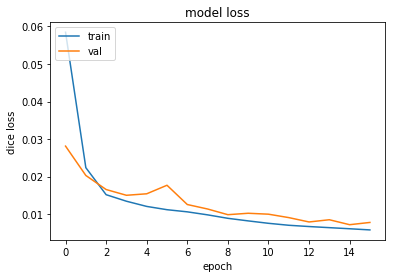

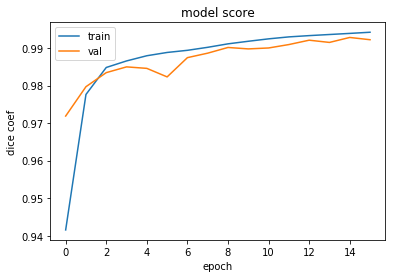

In [ ]:
# Plotting the dice coefficient and dice loss of training and validation sets
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('dice loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model score')
plt.ylabel('dice coef')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#Loading the test data
#X_test = np.load('./Test_Data/X_test.npy')
#Y_test = np.load('./Test_Data/Y_test.npy')

In [ ]:
#Predicting the output on test data
Y_pre = np.argmax(model.predict(X_test),axis=-1)

In [ ]:
np.unique(Y_pre)

array([0, 1, 2, 3])

In [ ]:
#Checking the shape
Y_pre.shape

(1386, 192, 192)

In [ ]:
#Reshaping 
Y_pre=Y_pre.reshape(-1,192,192,1)

In [ ]:
#Checking the shape
Y_test.shape,X_test.shape

((1386, 192, 192, 1), (1386, 192, 192, 4))

X_test 450


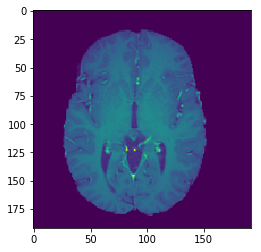

Predicted:- 


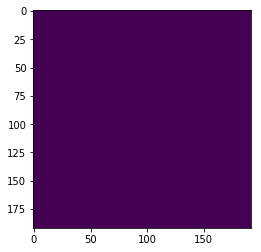

Actual:- 


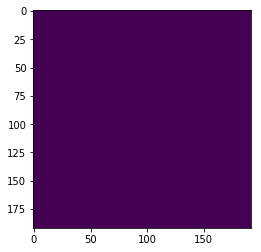

X_test 451


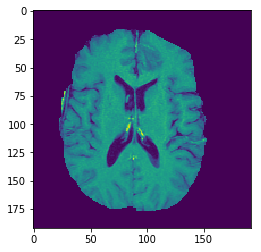

Predicted:- 


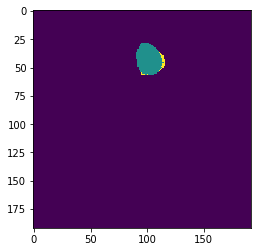

Actual:- 


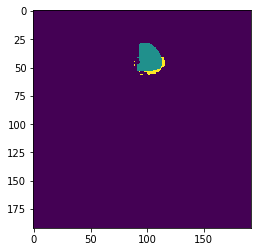

X_test 452


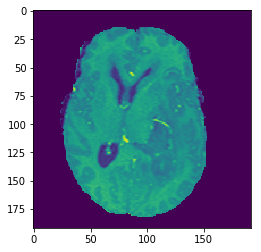

Predicted:- 


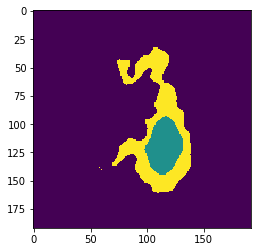

Actual:- 


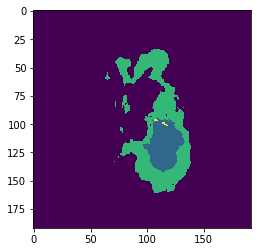

X_test 453


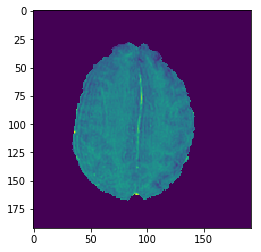

Predicted:- 


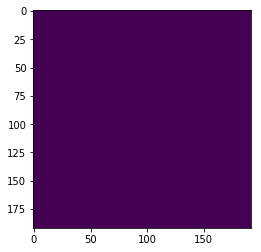

Actual:- 


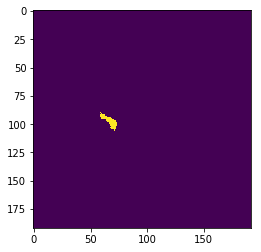

X_test 454


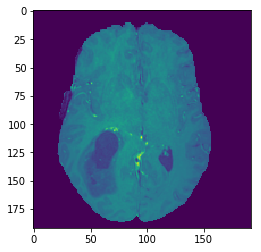

Predicted:- 


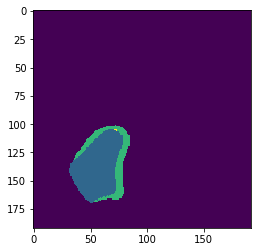

Actual:- 


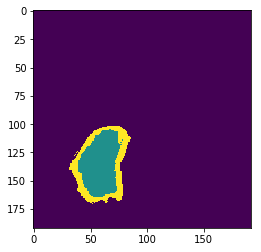

X_test 455


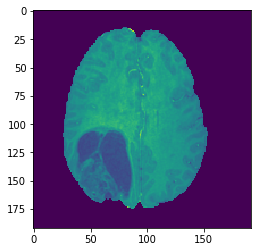

Predicted:- 


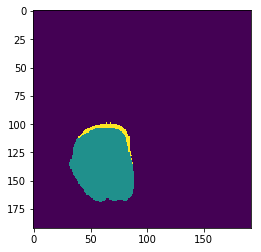

Actual:- 


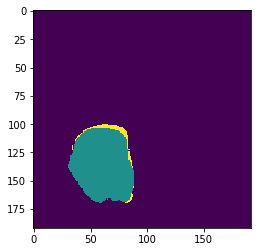

X_test 456


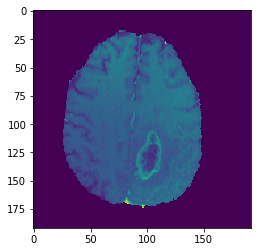

Predicted:- 


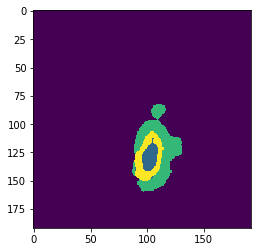

Actual:- 


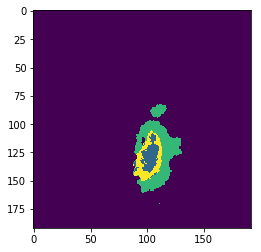

X_test 457


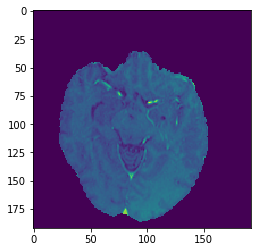

Predicted:- 


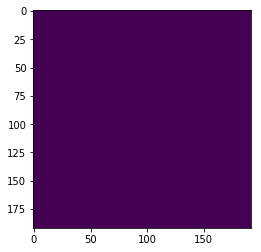

Actual:- 


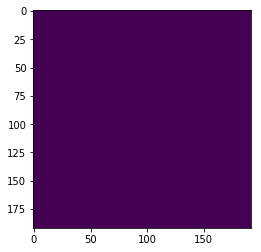

X_test 458


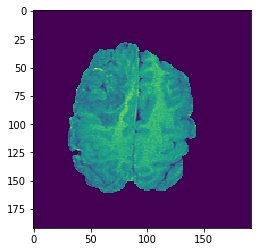

Predicted:- 


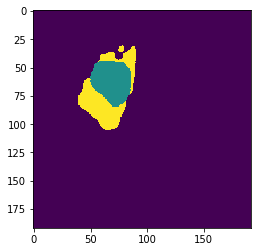

Actual:- 


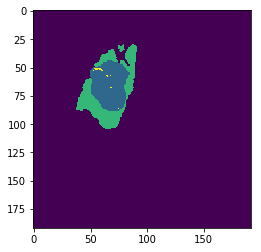

X_test 459


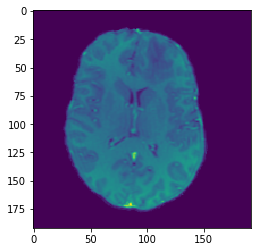

Predicted:- 


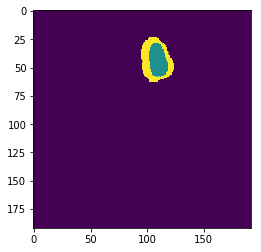

Actual:- 


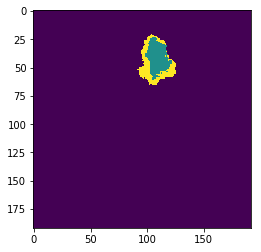

In [ ]:
#Showing the images 
for i in range(450,460):
    print('X_test '+ str(i))
    plt.imshow(X_test[i,:,:,2])
    plt.show()
    print('Predicted:- ')
    plt.imshow(Y_pre[i,:,:,0])
    plt.show()
    print('Actual:- ')
    plt.imshow(Y_test[i,:,:,0])
    plt.show()

In [ ]:
# converting to ctegorical
from keras.utils import to_categorical
Y_test_encod = to_categorical(Y_test)

In [ ]:
#Evaluating the model on the test set
model.evaluate(X_test,Y_test_encod,verbose=0)

[0.008249499698668117, 0.9917507540611994]

In [ ]:
#Saving the model
model.save('./Saved_Models/model.h5',overwrite=True)

#### Evaluation of the model

In [ ]:
#loading the test data
#X_test4 = np.load('./Test_Data/X_test.npy')
#Y_test4 = np.load('./Test_Data/Y_test.npy')

In [ ]:
#Converting to categorical
from keras.utils import to_categorical
Y_test_encod = to_categorical(Y_test)

In [ ]:
#Model compilation
model.compile(optimizer=Adam(lr=1e-5),loss=[dice_coef_loss],metrics=[dice_coef])

In [ ]:
#Loading model weights
model.load_weights('./Model_Checkpoints/weights.hdf5')

In [ ]:
#Printing dice coefficient
print('Dice Coefficient:- %.4f'%float(list(model.evaluate(X_test,Y_test_encod,batch_size=32,verbose=2))[1]))

Dice Coefficient:- 0.9918


In [ ]:
#Prediction
Y_pred = np.argmax(model.predict(X_test),axis=-1).reshape(-1,192,192,1)

Test slice no: 450


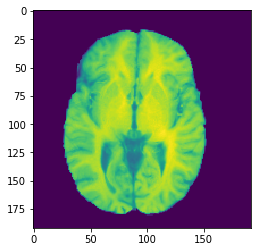

Predicted:- 


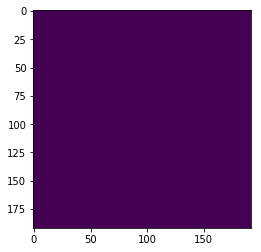

Actual:- 


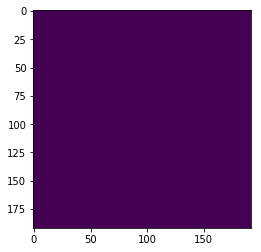

Test slice no: 451


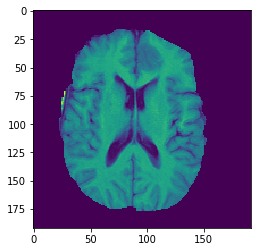

Predicted:- 


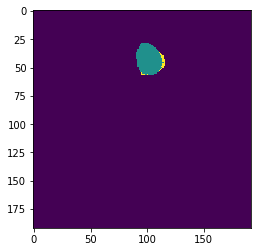

Actual:- 


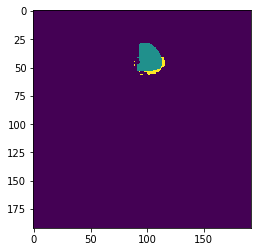

Test slice no: 452


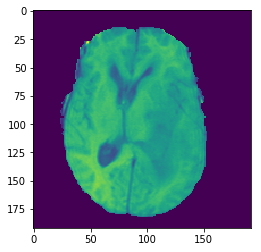

Predicted:- 


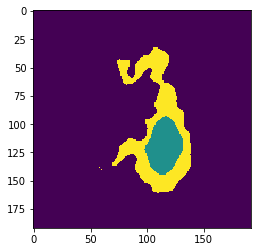

Actual:- 


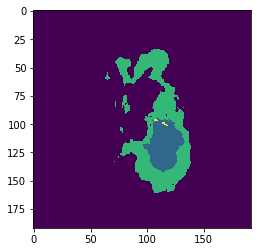

Test slice no: 453


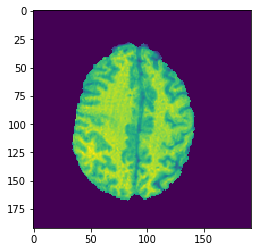

Predicted:- 


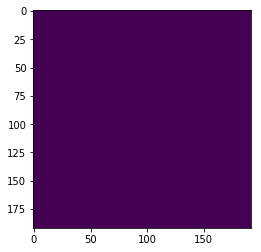

Actual:- 


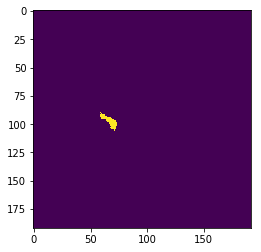

Test slice no: 454


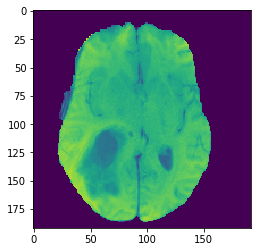

Predicted:- 


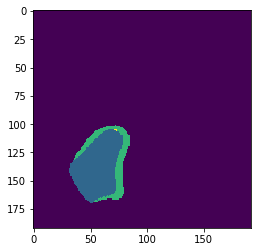

Actual:- 


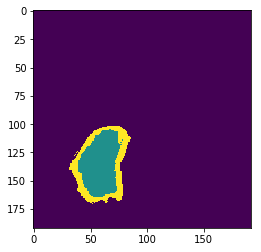

Test slice no: 455


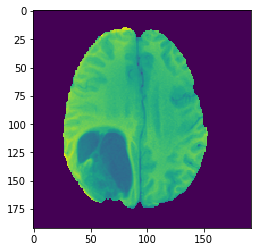

Predicted:- 


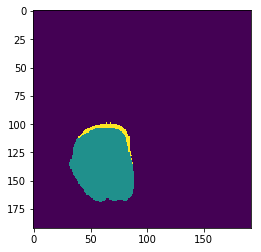

Actual:- 


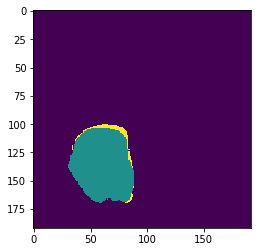

Test slice no: 456


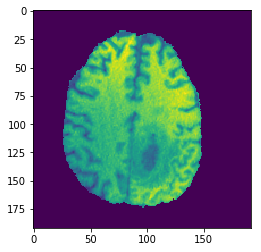

Predicted:- 


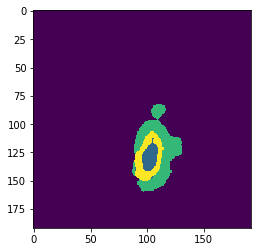

Actual:- 


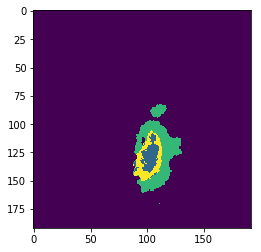

Test slice no: 457


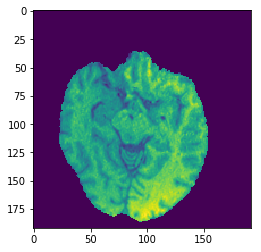

Predicted:- 


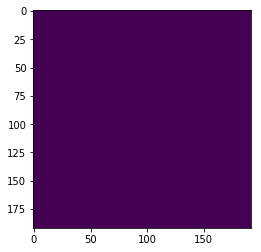

Actual:- 


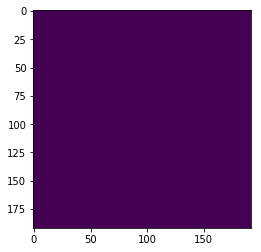

Test slice no: 458


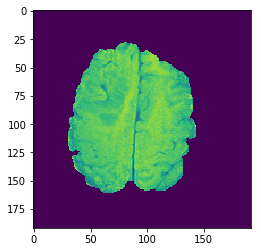

Predicted:- 


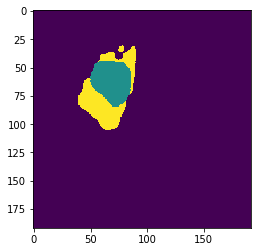

Actual:- 


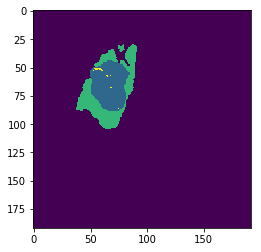

Test slice no: 459


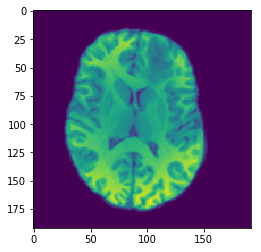

Predicted:- 


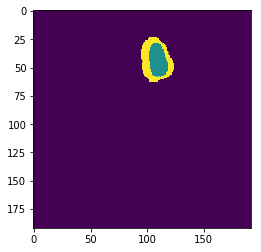

Actual:- 


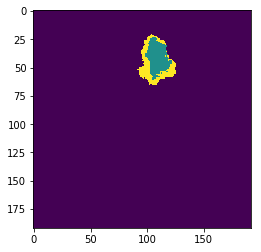

Test slice no: 460


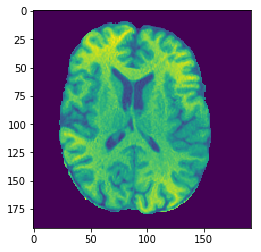

Predicted:- 


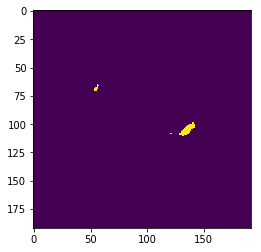

Actual:- 


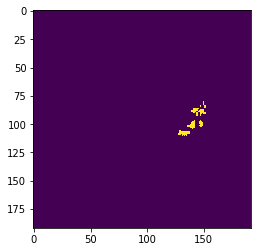

Test slice no: 461


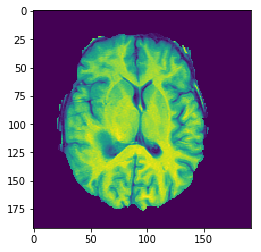

Predicted:- 


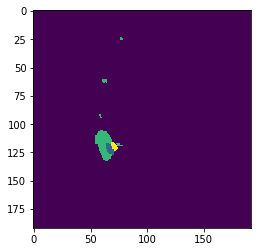

Actual:- 


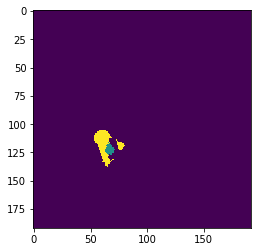

Test slice no: 462


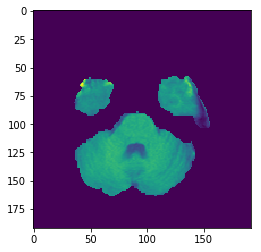

Predicted:- 


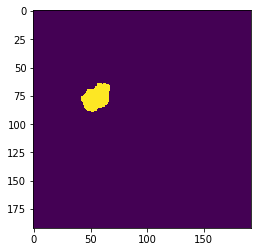

Actual:- 


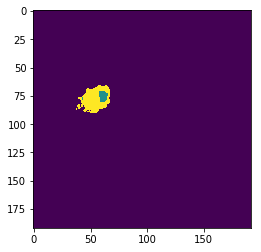

Test slice no: 463


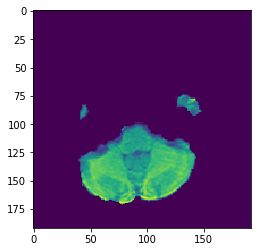

Predicted:- 


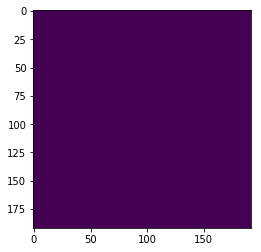

Actual:- 


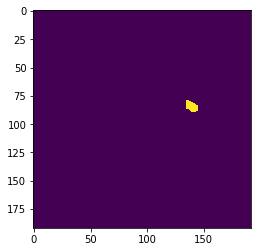

Test slice no: 464


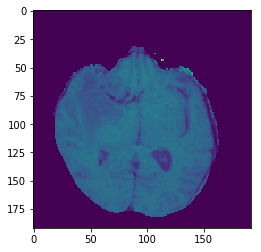

Predicted:- 


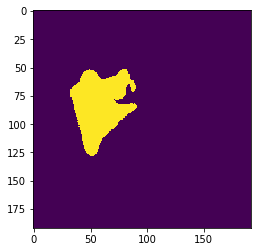

Actual:- 


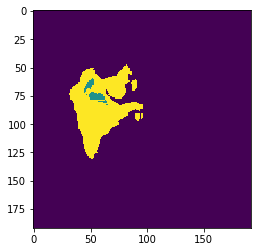

Test slice no: 465


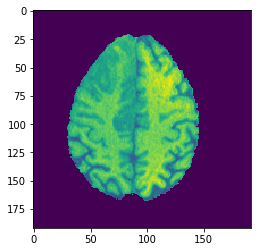

Predicted:- 


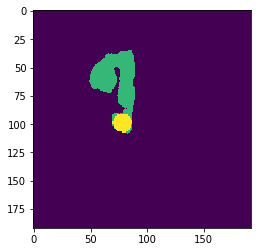

Actual:- 


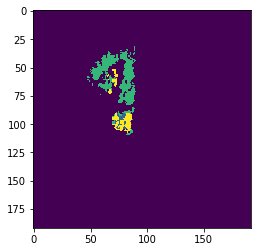

Test slice no: 466


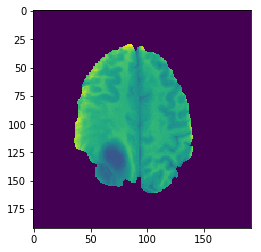

Predicted:- 


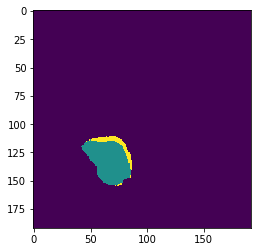

Actual:- 


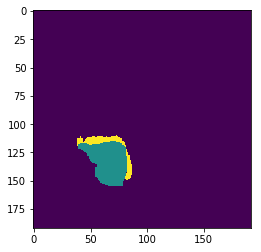

Test slice no: 467


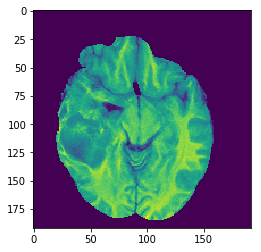

Predicted:- 


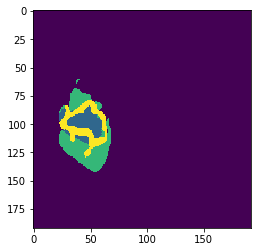

Actual:- 


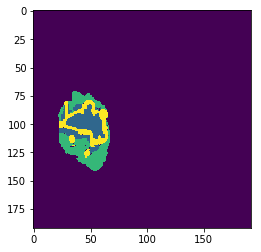

Test slice no: 468


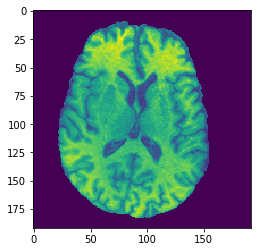

Predicted:- 


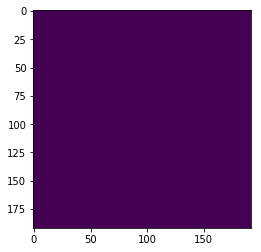

Actual:- 


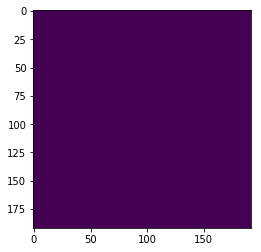

Test slice no: 469


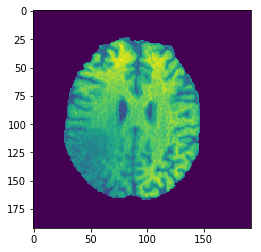

Predicted:- 


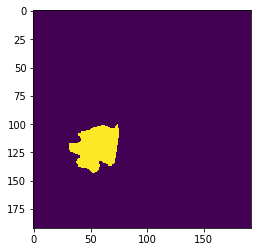

Actual:- 


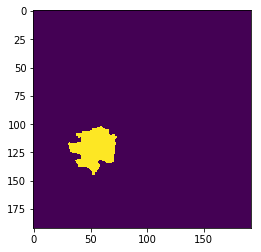

Test slice no: 470


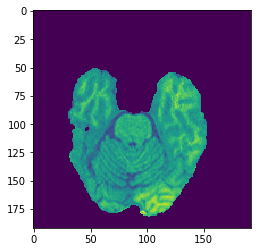

Predicted:- 


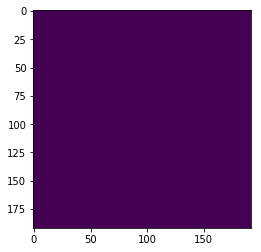

Actual:- 


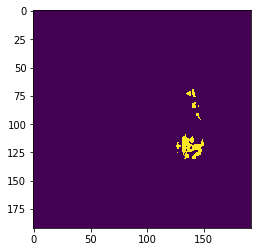

Test slice no: 471


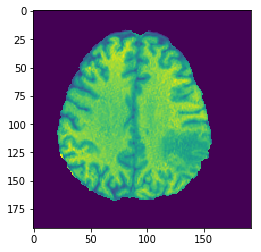

Predicted:- 


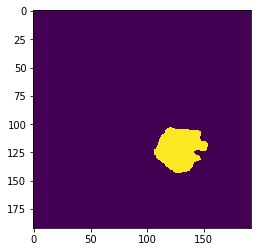

Actual:- 


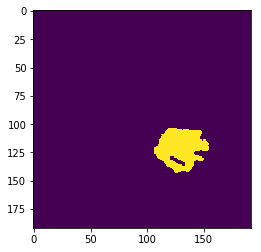

Test slice no: 472


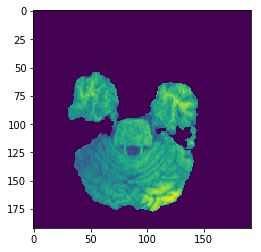

Predicted:- 


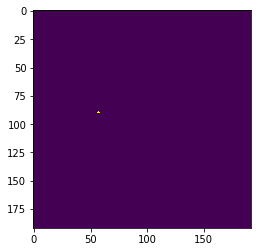

Actual:- 


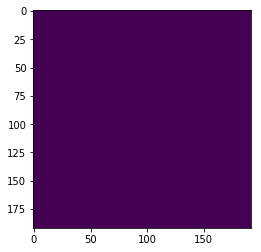

Test slice no: 473


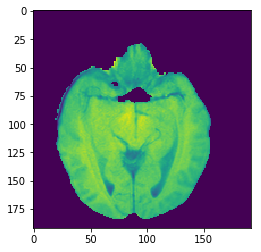

Predicted:- 


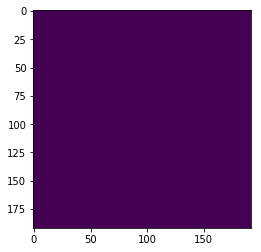

Actual:- 


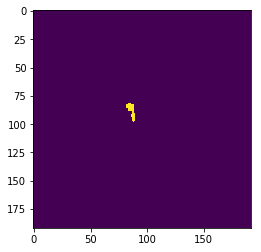

Test slice no: 474


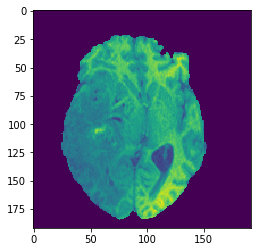

Predicted:- 


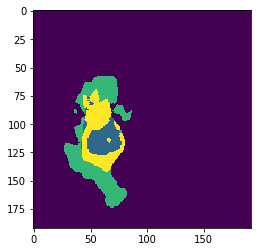

Actual:- 


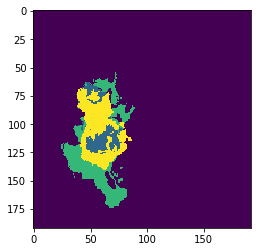

Test slice no: 475


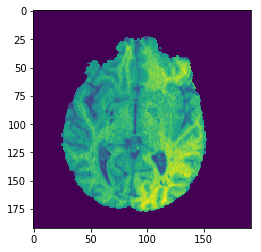

Predicted:- 


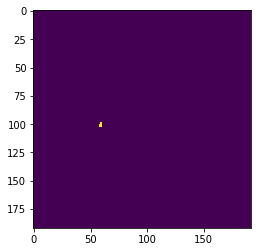

Actual:- 


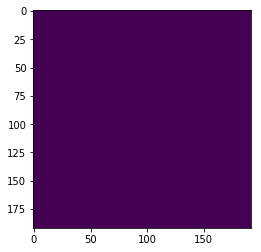

Test slice no: 476


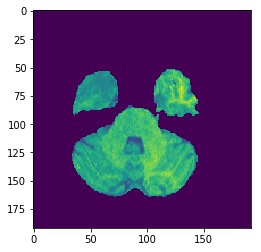

Predicted:- 


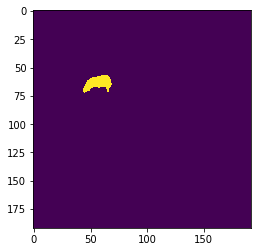

Actual:- 


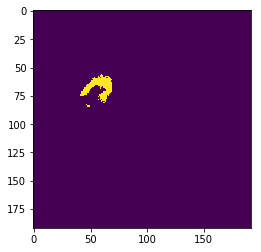

Test slice no: 477


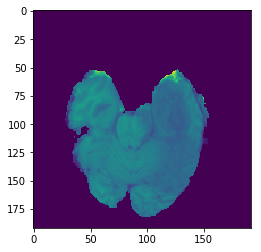

Predicted:- 


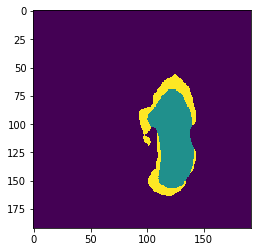

Actual:- 


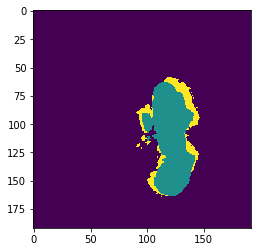

Test slice no: 478


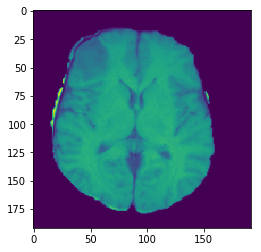

Predicted:- 


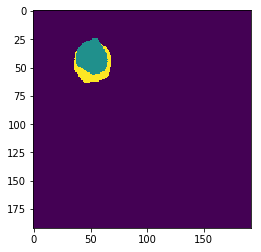

Actual:- 


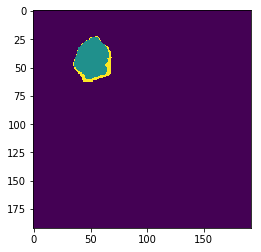

Test slice no: 479


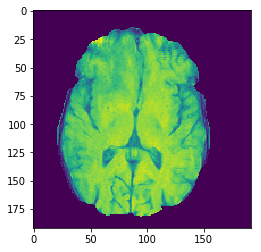

Predicted:- 


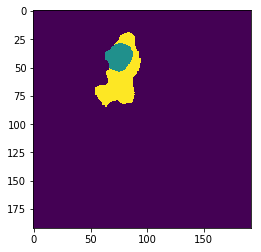

Actual:- 


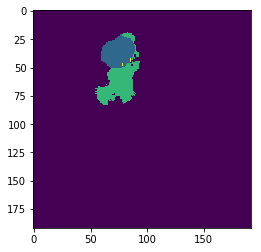

Test slice no: 480


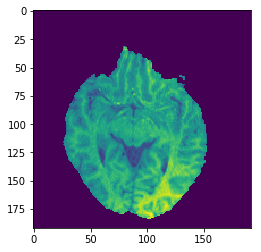

Predicted:- 


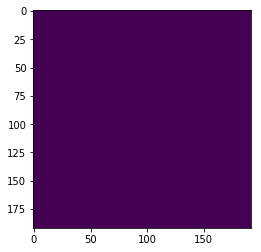

Actual:- 


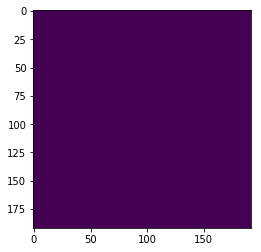

Test slice no: 481


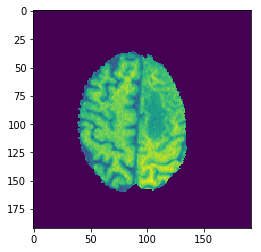

Predicted:- 


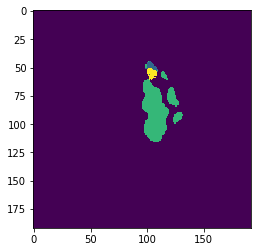

Actual:- 


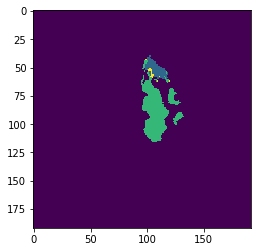

Test slice no: 482


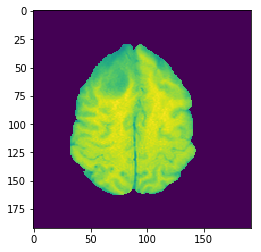

Predicted:- 


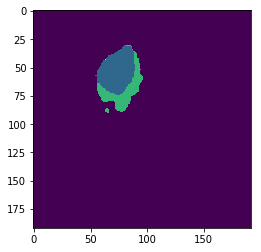

Actual:- 


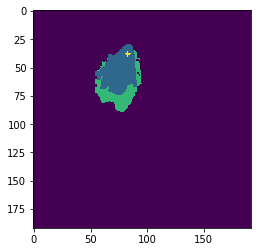

Test slice no: 483


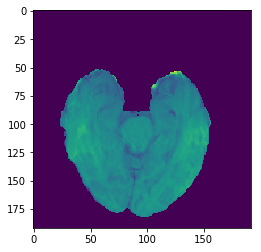

Predicted:- 


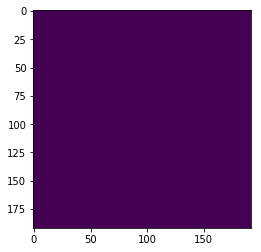

Actual:- 


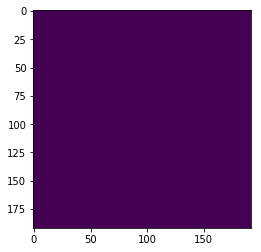

Test slice no: 484


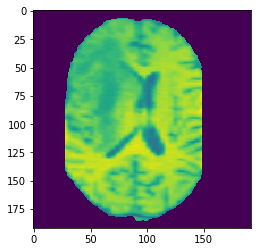

Predicted:- 


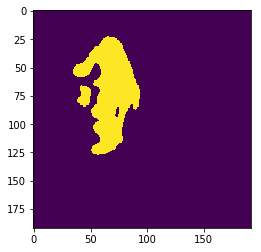

Actual:- 


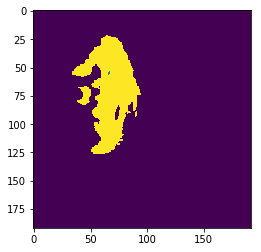

Test slice no: 485


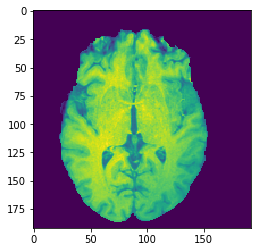

Predicted:- 


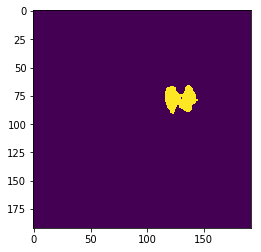

Actual:- 


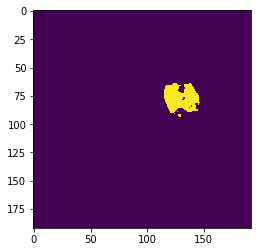

Test slice no: 486


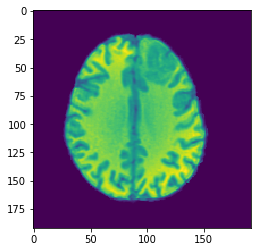

Predicted:- 


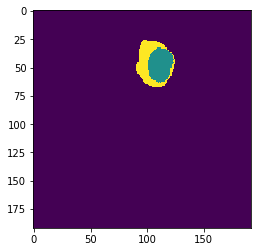

Actual:- 


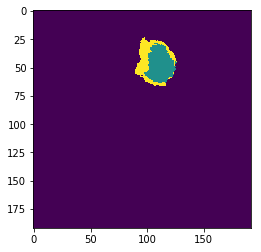

Test slice no: 487


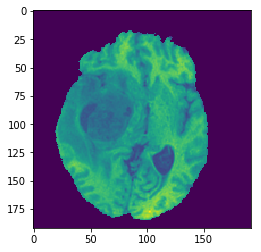

Predicted:- 


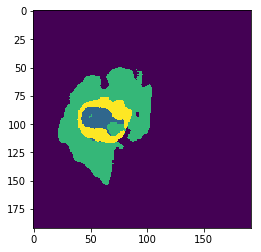

Actual:- 


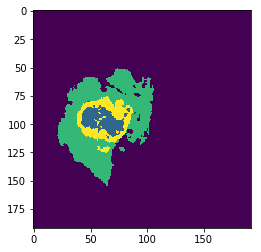

Test slice no: 488


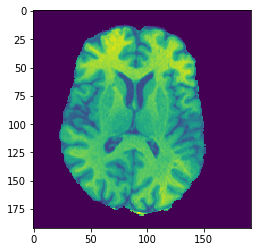

Predicted:- 


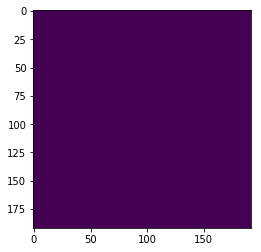

Actual:- 


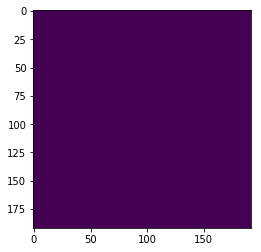

Test slice no: 489


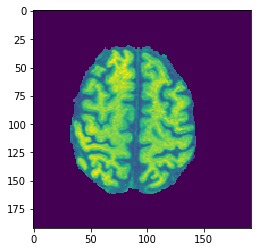

Predicted:- 


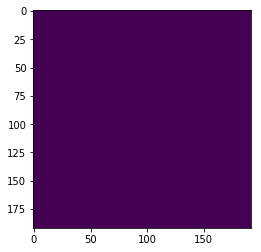

Actual:- 


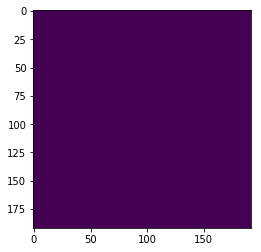

Test slice no: 490


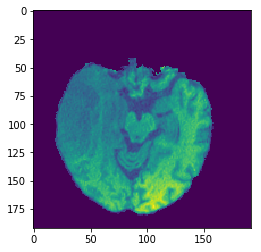

Predicted:- 


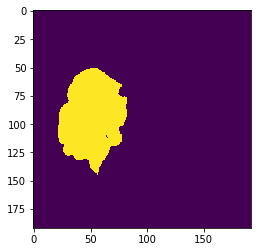

Actual:- 


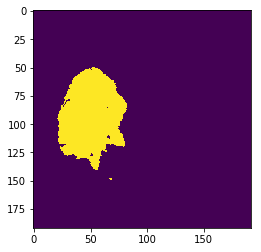

Test slice no: 491


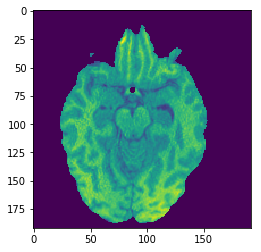

Predicted:- 


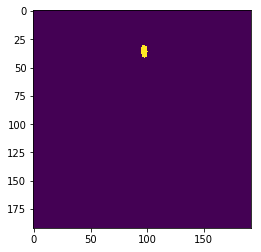

Actual:- 


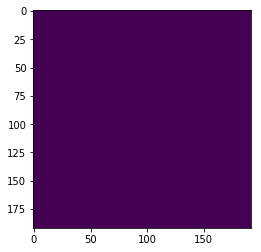

Test slice no: 492


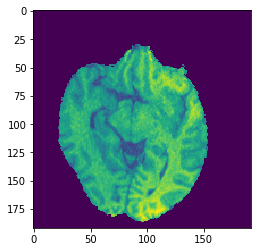

Predicted:- 


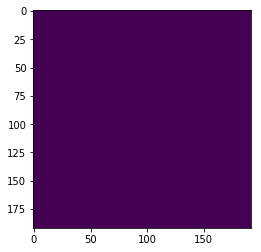

Actual:- 


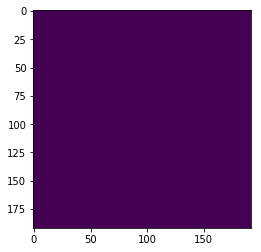

Test slice no: 493


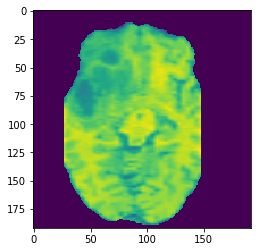

Predicted:- 


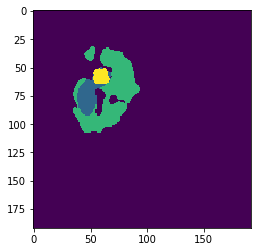

Actual:- 


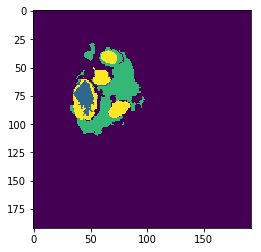

Test slice no: 494


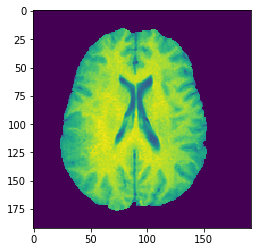

Predicted:- 


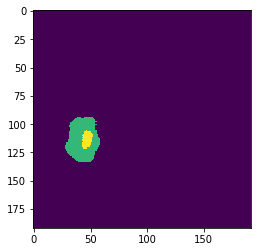

Actual:- 


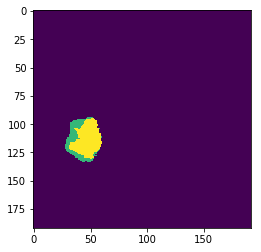

Test slice no: 495


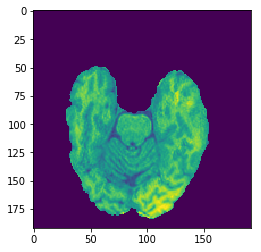

Predicted:- 


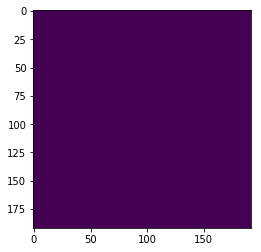

Actual:- 


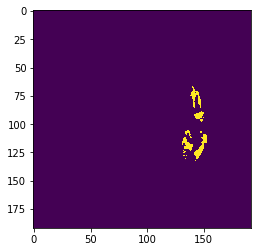

Test slice no: 496


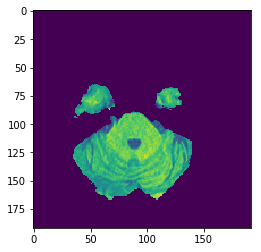

Predicted:- 


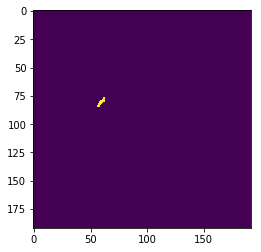

Actual:- 


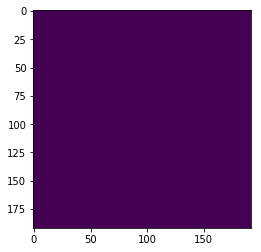

Test slice no: 497


In [ ]:
#showing the results
for i in range(450,500):
    print('Test slice no: ' + str(i))
    plt.imshow(X_test[i,:,:,1])
    plt.show()
    print('Predicted:- ')
    plt.imshow(Y_pred[i,:,:,0])
    plt.show()
    print('Actual:- ')
    plt.imshow(Y_test[i,:,:,0])
    plt.show()

#### Reference

https://github.com/as791/Multimodal-Brain-Tumor-Segmentation